In [1]:
# !pip install segmentation-models-pytorch

In [2]:
import numpy as np
import pandas as pd
import cv2
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import segmentation_models_pytorch as smp
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

from dataset_creator import S1Dataset, load_and_normalize_grayscale_image

In [3]:
import warnings
warnings.filterwarnings("ignore")

# Load saved data paths

In [4]:
df_train_paths = pd.read_csv("data/df_train_paths.csv")
df_train_paths_new = pd.read_csv("data/df_train_paths_new.csv")
df_valid_paths = pd.read_csv("data/df_valid_paths.csv")
df_test_paths = pd.read_csv("data/df_test_paths.csv")

# Transform datasets and create DataLoaders

The CustomTransform class facilitates image transformations for satellite data. It includes methods for horizontal and vertical flips, as well as a random resized crop. The \_\_call\_\_ method applies these transformations with a 50% probability each, offering a concise data augmentation pipeline for improved model training on satellite images.

In [5]:
class CustomTransform:
    def __init__(self, width, height):
        self.width = width
        self.height = height

    def horizontal_flip(self, image, mask=None):
        flipped_image = np.fliplr(image)
        flipped_mask = np.fliplr(mask) if mask is not None else None
        return flipped_image, flipped_mask

    def vertical_flip(self, image, mask=None):
        flipped_image = np.flipud(image)
        flipped_mask = np.flipud(mask) if mask is not None else None
        return flipped_image, flipped_mask

    def random_resized_crop(self, image, mask=None):
        h, w = image.shape[:2]

        x = np.random.randint(0, w - self.width + 1)
        y = np.random.randint(0, h - self.height + 1)

        cropped_image = image[y:y + self.height, x:x + self.width]
        cropped_mask = mask[y:y + self.height, x:x + self.width] if mask is not None else None

        resized_image = cv2.resize(cropped_image, (w, h))
        resized_mask = cv2.resize(cropped_mask, (w, h)) if mask is not None else None

        return resized_image, resized_mask

    def __call__(self, image, mask=None):
        # Apply transformations
        image, mask = self.horizontal_flip(image, mask) if np.random.rand() < 0.5 else (image, mask)
        image, mask = self.vertical_flip(image, mask) if np.random.rand() < 0.5 else (image, mask)
        image, mask = self.random_resized_crop(image, mask)

        return image, mask

In [6]:
custom_transform = CustomTransform(width=256, height=256)

train_set = S1Dataset(df_train_paths_new, flood_label=True, transform=custom_transform)
validation_set = S1Dataset(df_valid_paths, flood_label=True)

train_dataloader = DataLoader(train_set, batch_size=64, pin_memory=True, shuffle=False, num_workers=0)
validation_dataloader = DataLoader(validation_set, batch_size=64, pin_memory=True, shuffle=False, num_workers=0)

# Modeling

## Device selection

- Nvidia GPU, else CPU

In [7]:
# device = "cuda" if torch.cuda.is_available() else "cpu"

- macOS Apple's M-Series

In [8]:
device = "mps"

## Model

The U-Net with ResNet encoder was chosen for flood prediction from satellite images due to its superior feature extraction capabilities, well-suited architecture for image segmentation, incorporation of attention mechanisms, and efficient use of computational resources.

Due to the fact that the training will be conducted on RGB images, the in_channels parameter has been set to 3. Meanwhile, the classes parameter has been set to 2, as the model will predict whether there is a flood or not.

In [9]:
model = smp.Unet(encoder_name="resnet34", in_channels=3, classes=2, encoder_weights=None)

In [10]:
model.to(device)

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

## Training

In [11]:
def train_model(model, epochs, lr=0.001):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_function = nn.CrossEntropyLoss()
    
    for epoch in range(epochs):
        print(f"Epoch: {epoch}")
        progress_bar = tqdm(train_dataloader)
        model.train()
        
        for batch in progress_bar:
            image = batch["image"].to(device)
            mask = batch["mask"].to(device)

            pred = model(image)
            loss = loss_function(pred, mask)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            progress_bar.set_description(f"Loss: {loss.item():1.3f}")

        progress_bar = tqdm(validation_dataloader)
        model.eval()
        with torch.no_grad():
            for batch in progress_bar:
                image = batch["image"].to(device)
                mask = batch["mask"].to(device)

                pred = model(image)
                loss = loss_function(pred, mask)

                progress_bar.set_description(f"Loss: {loss.item():1.3f}")
    
    return model

Note that in the following training process, the progress bar dynamically updates. Therefore, after the cell is executed, the printed loss value at the end corresponds to some random batches from the dataset.

In [12]:
model = train_model(model, 20)

Epoch: 0


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

Epoch: 1


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

Epoch: 2


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

Epoch: 3


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

Epoch: 4


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

Epoch: 5


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

Epoch: 6


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

Epoch: 7


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

Epoch: 8


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

Epoch: 9


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

Epoch: 10


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

Epoch: 11


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

Epoch: 12


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

Epoch: 13


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

Epoch: 14


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

Epoch: 15


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

Epoch: 16


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

Epoch: 17


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

Epoch: 18


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

Epoch: 19


  0%|          | 0/426 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

## Save model

In [13]:
# torch.save(model.state_dict(), "model.pt")

## Load model

In [14]:
# model = smp.Unet(encoder_name="resnet34", in_channels=3, classes=2, encoder_weights=None)
# model.load_state_dict(torch.load("model.pt"))
# model.to(device)

## Test model

In [15]:
def predict(model, device, test_dataloader):
    predictions = []

    model.eval()
    with torch.no_grad():
        for batch in tqdm(test_dataloader):
            image = batch["image"].to(device)
            pred = model(image)
            pred_class = np.argmax(pred.cpu().numpy(), axis=1).astype("uint8")
            predictions.append(pred_class)
            
    return np.vstack(predictions)

In [16]:
test_set = S1Dataset(df_test_paths, flood_label=False)
test_dataloader = DataLoader(test_set, batch_size=64, pin_memory=True, shuffle=False, num_workers=0)

In [17]:
predictions = predict(model, device, test_dataloader)

  0%|          | 0/163 [00:00<?, ?it/s]

# Final results visualizations

In [18]:
def plot_prediction(sample, prediction):
    vv_channel = load_and_normalize_grayscale_image(sample["vv_channel"])
    vh_channel = load_and_normalize_grayscale_image(sample["vh_channel"])
    
    ratio = np.clip(np.nan_to_num(vv_channel/vh_channel, 0), 0, 1)
    rgb_original = np.stack((vv_channel, vh_channel, 1-ratio), axis=2)

    fig, axs = plt.subplots(1, 2, figsize=(15, 10))
    axs[0].imshow(rgb_original)
    axs[0].set_title("Original RGB image")
    axs[1].imshow(prediction)
    axs[1].set_title("Flood prediction")
    
    for ax in axs.flat:
        ax.set_xticks([])
        ax.set_yticks([])

Despite a limited number of training epochs due to extensive computational requirements, the model proved quite effective in predicting floods in areas not labeled (test dataset).

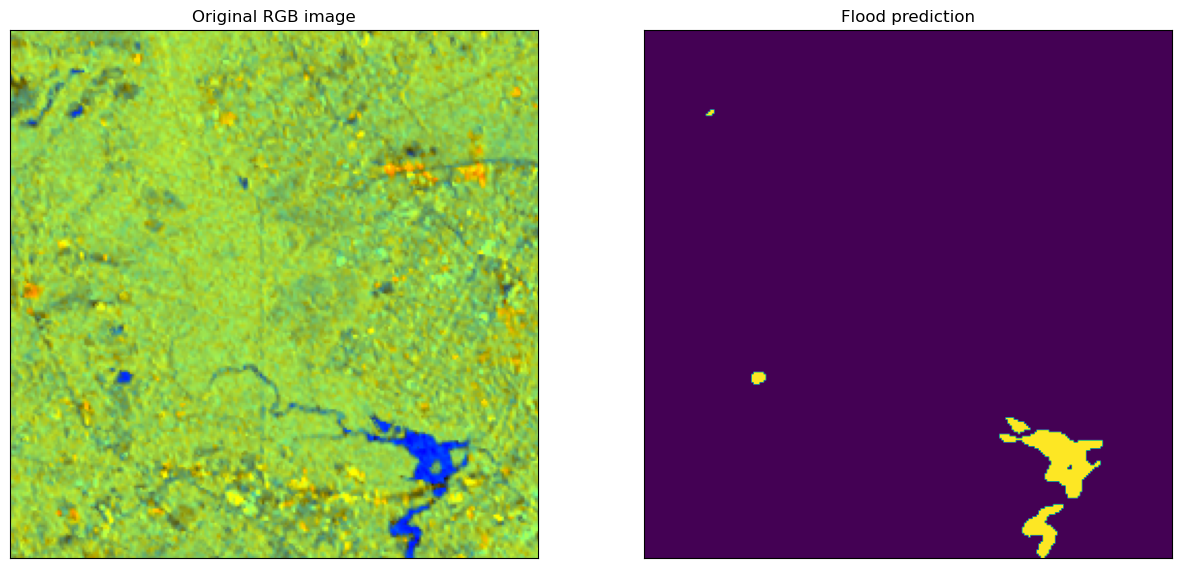

In [19]:
plot_prediction(df_test_paths.iloc[1905], predictions[1905])

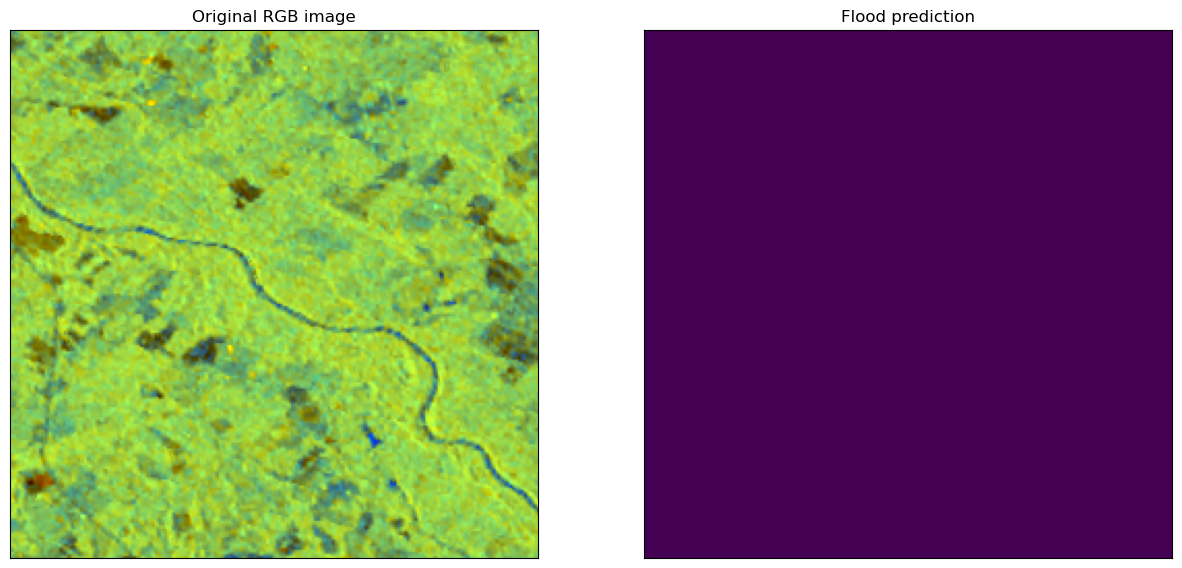

In [20]:
plot_prediction(df_test_paths.iloc[2967], predictions[2967])

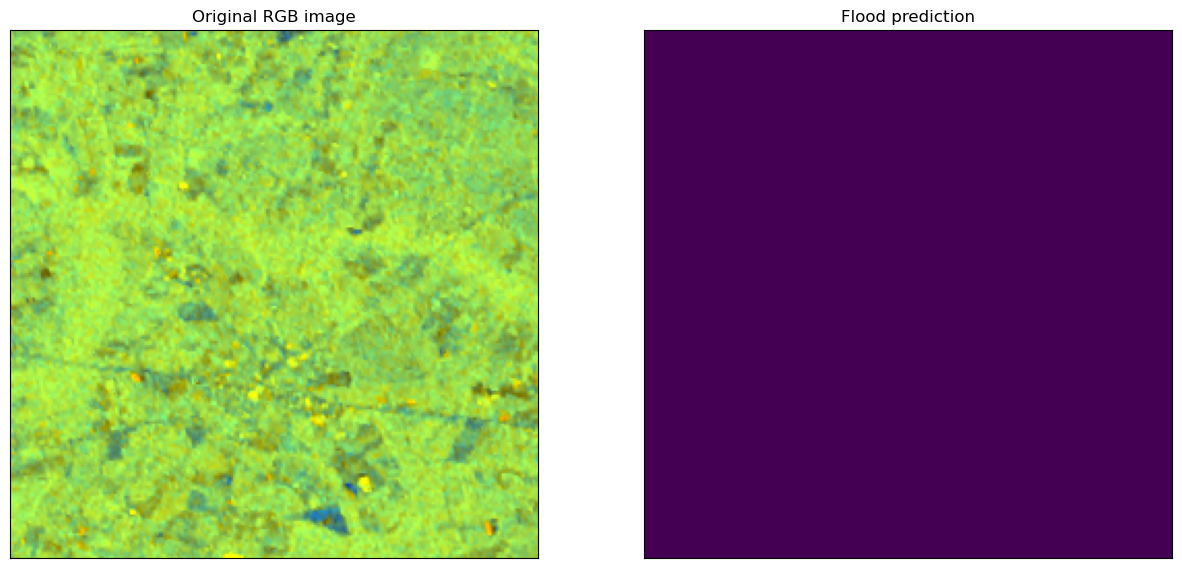

In [21]:
plot_prediction(df_test_paths.iloc[9100], predictions[9100])

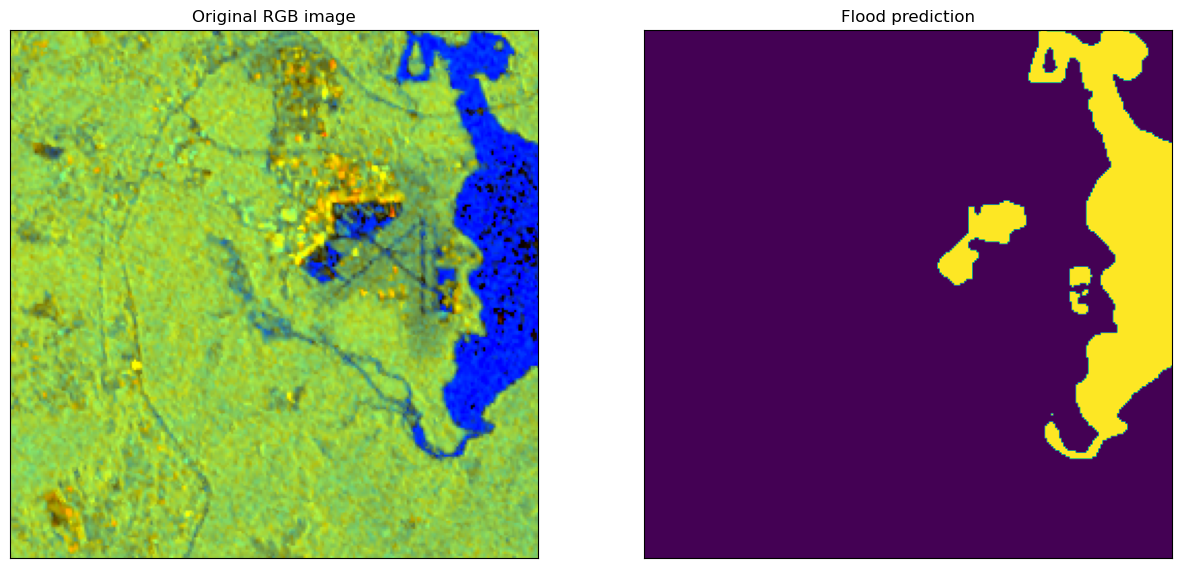

In [22]:
plot_prediction(df_test_paths.iloc[1945], predictions[1945])

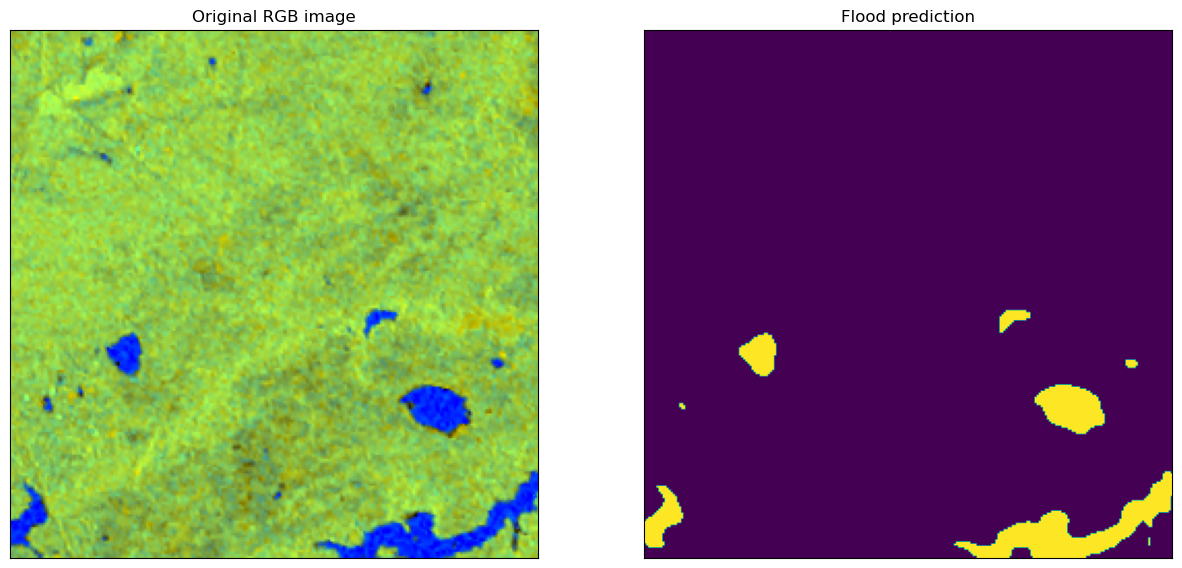

In [23]:
plot_prediction(df_test_paths.iloc[6457], predictions[6457])